In [6]:
# %%

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math as m
import tables
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from optparse import OptionParser
from matplotlib.colors import LogNorm,Normalize
from pylab import *
from scipy.interpolate import interp1d, UnivariateSpline
import glob

# %%
name_nu_1 = []


# %% add the input file path here
#name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuE_G1.0_E3:7_Z0:180_1_csms_FullnoGR.h5') # my file full sim
name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuTau:NuTauBar_G1.0_E3:7_Z0:180_1_csms_020_FullnoGR.h5') # my file full sim

#name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuTau_CSMS_1_2.h5') # my file full sim
#name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuTau:NuTauBar_G1.0_E3:7_Z0:180_1_csms_FullnoGR.h5') # my file NuGeN Only

### YX files
#name_nu_1 = glob.glob('/data/user/joanna/CSecGen-Data/100_v4/nugen_nodetector_nutau_100_50*.h5') #YX file


# %%
name_nu_1  =name_nu_1[:1]


# %%
len(name_nu_1)

# %%
NFiles_nu_1 =  2000.*np.ones(1)

# %%


pdist = lambda p1, p2 : ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

def weight_cal(f,fit,NFiles,livetime,selfveto):
    if fit == 0:
        index=-2
        norm_astro=1
        norm_conv=1
        norm_prompt=1
    elif fit == 2:
        index=-2.67
        norm_astro=2.15
        norm_conv=0.84
        norm_prompt=0.47
    elif fit == 1:
        index = -2.73
        norm_astro=2.2
        norm_conv=0.85
        norm_prompt=0.3
    elif fit == 8:
        index = -2.48
        norm_astro = 1.61
        norm_conv = 1.06
        norm_prompt = 1.

    OneWeight=f.root.I3MCWeightDict.col('OneWeight')
    NEvents=f.root.I3MCWeightDict.col('NEvents')
    PrimaryNeutrinoEnergy=f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy')
    print('NEvents=',NEvents)
    print('NFiles=',NFiles)

    
    astro_weight = OneWeight/(NEvents*NFiles)*1.0e-18*np.power(PrimaryNeutrinoEnergy/100000,index)*norm_astro*livetime
    return astro_weight


class variable:
    def __init__(self,f,year,NFiles):
        self.f=f
        self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalXsectionCGS')*1.0e27) #converting xsec unit from cm^2 to mb
        #self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalCrosssectionCGS')*1.0e27) #converting xsec unit from cm^2 to mb #YX files
        #self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalXsectionCGS')*1.0e27)
        fit = 8
        #livetime = 1.0*3600*24*365*5
        #livetime = 1.0
        livetime = 1.0*(31.04*3600*24+3156904+2820269+2909466+2966167)
        #self.weight_wo_sv=weight_cal(self.f,fit,NFiles,livetime,0)
        self.weight=weight_cal(self.f,fit,NFiles,livetime,0)


        self.zenith = np.cos(f.root.I3MCWeightDict.col('PrimaryNeutrinoZenith'))
        #self.inice_primary_energy = np.log10(f.root.cscdSBU_MCInIcePrimary.col('energy')) #YX files
        self.inice_primary_energy = np.log10(f.root.I3MCWeightDict.col('InIceNeutrinoEnergy'))
        self.primary_energy = np.log10(f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy'))
        self.diff = (np.power(10,self.primary_energy)-np.power(10,self.inice_primary_energy))/np.power(10,self.primary_energy)*100.0
        #self.prop=f.root.I3MCWeightDict.col('TotalPropagationProbability')
        #self.prop=f.root.I3MCWeightDict.col('PropagationWeight')
        #self.type= f.root.I3MCWeightDict.col('PrimaryNeutrinoType')
        #self.inter_type = f.root.I3MCWeightDict.col('InteractionType')
        #self.energy = np.log10(f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy'))
    

def selection(sample):
    #idx = sample.zenith > -100
    idx = np.isfinite(sample.xsec)
    idx = np.logical_and(idx,np.logical_not(np.isnan(sample.zenith)))
    idx = np.logical_and(idx,np.logical_not(np.isnan(sample.primary_energy)))
    idx = np.logical_and(idx,np.logical_not(np.isnan(sample.inice_primary_energy)))
    idx = np.logical_and(idx,np.logical_not(np.isnan(sample.weight)))
    return idx


seperation = 0.

function = selection

nu_1_inice=[]
nu_1_zenith=[]
nu_1_weight=[]
nu_1_diff=[]
nu_1_prim=[]
nu_1_xsec=[]



for file, nfiles in zip(name_nu_1,NFiles_nu_1):
    file_nu = tables.open_file(file)
    v_nu = variable(file_nu,2011,nfiles)
    idx_nu = function(v_nu)
    nu_1_inice = np.concatenate((nu_1_inice,v_nu.inice_primary_energy[idx_nu]))
    nu_1_zenith = np.concatenate((nu_1_zenith,v_nu.zenith[idx_nu]))
    nu_1_weight = np.concatenate((nu_1_weight,v_nu.weight[idx_nu]))
    nu_1_diff = np.concatenate((nu_1_diff,v_nu.diff[idx_nu]))
    nu_1_prim = np.concatenate((nu_1_prim,v_nu.primary_energy[idx_nu]))
    nu_1_xsec = np.concatenate((nu_1_xsec,v_nu.xsec[idx_nu]))
    file_nu.close()

# %%
print('number of raw events:',len(nu_1_zenith))
idx_nu_1_up = nu_1_zenith<seperation
idx_nu_1_down = nu_1_zenith>=seperation

inice_1_up = nu_1_inice[idx_nu_1_up]
inice_1_down = nu_1_inice[idx_nu_1_down]

weight_1_up = nu_1_weight[idx_nu_1_up]
weight_1_down = nu_1_weight[idx_nu_1_down]

xsec_1_up = nu_1_xsec[idx_nu_1_up]
xsec_1_down = nu_1_xsec[idx_nu_1_down]

diff_1_up = nu_1_diff[idx_nu_1_up]
diff_1_down = nu_1_diff[idx_nu_1_down]


prim_1_up = nu_1_prim[idx_nu_1_up]
prim_1_down = nu_1_prim[idx_nu_1_down]




NEvents= [1000000. 1000000. 1000000. ... 1000000. 1000000. 1000000.]
NFiles= 2000.0
number of raw events: 1000000


In [35]:
csms_02=getupanddown('/data/user/hhamdaoui/reproduce/NuTau:NuTauBar_G1.0_E3:7_Z0:180_1_csms_020_FullnoGR.h5')
csms_5=getupanddown('/data/user/hhamdaoui/reproduce/NuTau:NuTauBar_G1.0_E3:7_Z0:180_1_csms_500_FullnoGR.h5')
csms_1=getupanddown('/data/user/hhamdaoui/reproduce/NuTau:NuTauBar_G1.0_E3:7_Z0:180_1_csms_FullnoGR.h5')

csms_1_yx=getupanddownyx('/data/user/joanna/CSecGen-Data/100_v4/nugen_nodetector_nutau_100_50*.h5')
csms_02_yx=getupanddownyx('/data/user/joanna/CSecGen-Data/020_v4/nugen_nodetector_nutau_020_50*.h5')
csms_5_yx=getupanddownyx('/data/user/joanna/CSecGen-Data/500_v4/nugen_nodetector_nutau_500_50*.h5')


NEvents= [1000000. 1000000. 1000000. ... 1000000. 1000000. 1000000.]
NFiles= 2000.0
number of raw events: 1000000


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in log10


NEvents= [1000000. 1000000. 1000000. ... 1000000. 1000000. 1000000.]
NFiles= 2000.0


/cvmfs/icecube.opensciencegrid.org/py3-v4.1.1/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log10


number of raw events: 999992
NEvents= [1000000. 1000000. 1000000. ... 1000000. 1000000. 1000000.]
NFiles= 2000.0
number of raw events: 999998
NEvents= [50000. 50000. 50000. ... 50000. 50000. 50000.]
NFiles= 2000.0
number of raw events: 499894
NEvents= [50000. 50000. 50000. ... 50000. 50000. 50000.]
NFiles= 2000.0
number of raw events: 499982
NEvents= [50000. 50000. 50000. ... 50000. 50000. 50000.]
NFiles= 2000.0
number of raw events: 499448


In [20]:
def getupanddown(input_file):
    # %%
    name_nu_1 = []


    # %% add the input file path here
    #name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuE_G1.0_E3:7_Z0:180_1_csms_FullnoGR.h5') # my file full sim
    name_nu_1 = glob.glob(input_file) # my file full sim

    #name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuTau_CSMS_1_2.h5') # my file full sim
    #name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuTau:NuTauBar_G1.0_E3:7_Z0:180_1_csms_FullnoGR.h5') # my file NuGeN Only

    ### YX files
    #name_nu_1 = glob.glob('/data/user/joanna/CSecGen-Data/100_v4/nugen_nodetector_nutau_100_50*.h5') #YX file


    # %%
    name_nu_1  =name_nu_1[:1]


    # %%
    len(name_nu_1)

    # %%
    NFiles_nu_1 =  2000.*np.ones(1)

    # %%


    pdist = lambda p1, p2 : ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

    def weight_cal(f,fit,NFiles,livetime,selfveto):
        if fit == 0:
            index=-2
            norm_astro=1
            norm_conv=1
            norm_prompt=1
        elif fit == 2:
            index=-2.67
            norm_astro=2.15
            norm_conv=0.84
            norm_prompt=0.47
        elif fit == 1:
            index = -2.73
            norm_astro=2.2
            norm_conv=0.85
            norm_prompt=0.3
        elif fit == 8:
            index = -2.48
            norm_astro = 1.61
            norm_conv = 1.06
            norm_prompt = 1.

        OneWeight=f.root.I3MCWeightDict.col('OneWeight')
        NEvents=f.root.I3MCWeightDict.col('NEvents')
        PrimaryNeutrinoEnergy=f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy')
        print('NEvents=',NEvents)
        print('NFiles=',NFiles)

        
        astro_weight = OneWeight/(NEvents*NFiles)*1.0e-18*np.power(PrimaryNeutrinoEnergy/100000,index)*norm_astro*livetime
        return astro_weight


    class variable:
        def __init__(self,f,year,NFiles):
            self.f=f
            self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalXsectionCGS')*1.0e27) #converting xsec unit from cm^2 to mb
            #self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalCrosssectionCGS')*1.0e27) #converting xsec unit from cm^2 to mb #YX files
            #self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalXsectionCGS')*1.0e27)
            fit = 8
            #livetime = 1.0*3600*24*365*5
            #livetime = 1.0
            livetime = 1.0*(31.04*3600*24+3156904+2820269+2909466+2966167)
            #self.weight_wo_sv=weight_cal(self.f,fit,NFiles,livetime,0)
            self.weight=weight_cal(self.f,fit,NFiles,livetime,0)


            self.zenith = np.cos(f.root.I3MCWeightDict.col('PrimaryNeutrinoZenith'))
            #self.inice_primary_energy = np.log10(f.root.cscdSBU_MCInIcePrimary.col('energy')) #YX files
            self.inice_primary_energy = np.log10(f.root.I3MCWeightDict.col('InIceNeutrinoEnergy'))
            self.primary_energy = np.log10(f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy'))
            self.diff = (np.power(10,self.primary_energy)-np.power(10,self.inice_primary_energy))/np.power(10,self.primary_energy)*100.0
            #self.prop=f.root.I3MCWeightDict.col('TotalPropagationProbability')
            #self.prop=f.root.I3MCWeightDict.col('PropagationWeight')
            #self.type= f.root.I3MCWeightDict.col('PrimaryNeutrinoType')
            #self.inter_type = f.root.I3MCWeightDict.col('InteractionType')
            #self.energy = np.log10(f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy'))
        

    def selection(sample):
        #idx = sample.zenith > -100
        idx = np.isfinite(sample.xsec)
        idx = np.logical_and(idx,np.logical_not(np.isnan(sample.zenith)))
        idx = np.logical_and(idx,np.logical_not(np.isnan(sample.primary_energy)))
        idx = np.logical_and(idx,np.logical_not(np.isnan(sample.inice_primary_energy)))
        idx = np.logical_and(idx,np.logical_not(np.isnan(sample.weight)))
        return idx


    seperation = 0.

    function = selection

    nu_1_inice=[]
    nu_1_zenith=[]
    nu_1_weight=[]
    nu_1_diff=[]
    nu_1_prim=[]
    nu_1_xsec=[]



    for file, nfiles in zip(name_nu_1,NFiles_nu_1):
        file_nu = tables.open_file(file)
        v_nu = variable(file_nu,2011,nfiles)
        idx_nu = function(v_nu)
        nu_1_inice = np.concatenate((nu_1_inice,v_nu.inice_primary_energy[idx_nu]))
        nu_1_zenith = np.concatenate((nu_1_zenith,v_nu.zenith[idx_nu]))
        nu_1_weight = np.concatenate((nu_1_weight,v_nu.weight[idx_nu]))
        nu_1_diff = np.concatenate((nu_1_diff,v_nu.diff[idx_nu]))
        nu_1_prim = np.concatenate((nu_1_prim,v_nu.primary_energy[idx_nu]))
        nu_1_xsec = np.concatenate((nu_1_xsec,v_nu.xsec[idx_nu]))
        file_nu.close()

    # %%
    print('number of raw events:',len(nu_1_zenith))
    idx_nu_1_up = nu_1_zenith<seperation
    idx_nu_1_down = nu_1_zenith>=seperation

    inice_1_up = nu_1_inice[idx_nu_1_up]
    inice_1_down = nu_1_inice[idx_nu_1_down]

    weight_1_up = nu_1_weight[idx_nu_1_up]
    weight_1_down = nu_1_weight[idx_nu_1_down]

    xsec_1_up = nu_1_xsec[idx_nu_1_up]
    xsec_1_down = nu_1_xsec[idx_nu_1_down]

    diff_1_up = nu_1_diff[idx_nu_1_up]
    diff_1_down = nu_1_diff[idx_nu_1_down]


    prim_1_up = nu_1_prim[idx_nu_1_up]
    prim_1_down = nu_1_prim[idx_nu_1_down]
    d= {}
    d['prim_1_up']=prim_1_up
    d['weight_1_up']=weight_1_up
    d['prim_1_down']=prim_1_down
    d['weight_1_down']=weight_1_down
    d['nu_1_zenith']=nu_1_zenith
    
    return d




In [ ]:
def getupanddownyx(input_file):
    # %%
    name_nu_1 = []


    # %% add the input file path here
    #name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuE_G1.0_E3:7_Z0:180_1_csms_FullnoGR.h5') # my file full sim
    name_nu_1 = glob.glob(input_file) # my file full sim

    #name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuTau_CSMS_1_2.h5') # my file full sim
    #name_nu_1 = glob.glob('/data/user/hhamdaoui/reproduce/NuTau:NuTauBar_G1.0_E3:7_Z0:180_1_csms_FullnoGR.h5') # my file NuGeN Only

    ### YX files
    #name_nu_1 = glob.glob('/data/user/joanna/CSecGen-Data/100_v4/nugen_nodetector_nutau_100_50*.h5') #YX file


    # %%
    name_nu_1  =name_nu_1[:1]


    # %%
    len(name_nu_1)

    # %%
    NFiles_nu_1 =  2000.*np.ones(1)

    # %%


    pdist = lambda p1, p2 : ((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2 + (p1[2]-p2[2])**2)

    def weight_cal(f,fit,NFiles,livetime,selfveto):
        if fit == 0:
            index=-2
            norm_astro=1
            norm_conv=1
            norm_prompt=1
        elif fit == 2:
            index=-2.67
            norm_astro=2.15
            norm_conv=0.84
            norm_prompt=0.47
        elif fit == 1:
            index = -2.73
            norm_astro=2.2
            norm_conv=0.85
            norm_prompt=0.3
        elif fit == 8:
            index = -2.48
            norm_astro = 1.61
            norm_conv = 1.06
            norm_prompt = 1.

        OneWeight=f.root.I3MCWeightDict.col('OneWeight')
        NEvents=f.root.I3MCWeightDict.col('NEvents')
        PrimaryNeutrinoEnergy=f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy')
        print('NEvents=',NEvents)
        print('NFiles=',NFiles)

        
        astro_weight = OneWeight/(NEvents*NFiles)*1.0e-18*np.power(PrimaryNeutrinoEnergy/100000,index)*norm_astro*livetime
        return astro_weight


    class variable:
        def __init__(self,f,year,NFiles):
            self.f=f
            #self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalXsectionCGS')*1.0e27) #converting xsec unit from cm^2 to mb
            self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalCrosssectionCGS')*1.0e27) #converting xsec unit from cm^2 to mb #YX files
            #self.xsec = np.log10(f.root.I3MCWeightDict.col('TotalXsectionCGS')*1.0e27)
            fit = 8
            #livetime = 1.0*3600*24*365*5
            #livetime = 1.0
            livetime = 1.0*(31.04*3600*24+3156904+2820269+2909466+2966167)
            #self.weight_wo_sv=weight_cal(self.f,fit,NFiles,livetime,0)
            self.weight=weight_cal(self.f,fit,NFiles,livetime,0)


            self.zenith = np.cos(f.root.I3MCWeightDict.col('PrimaryNeutrinoZenith'))
            self.inice_primary_energy = np.log10(f.root.cscdSBU_MCInIcePrimary.col('energy')) #YX files
            #self.inice_primary_energy = np.log10(f.root.I3MCWeightDict.col('InIceNeutrinoEnergy'))
            self.primary_energy = np.log10(f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy'))
            self.diff = (np.power(10,self.primary_energy)-np.power(10,self.inice_primary_energy))/np.power(10,self.primary_energy)*100.0
            #self.prop=f.root.I3MCWeightDict.col('TotalPropagationProbability')
            #self.prop=f.root.I3MCWeightDict.col('PropagationWeight')
            #self.type= f.root.I3MCWeightDict.col('PrimaryNeutrinoType')
            #self.inter_type = f.root.I3MCWeightDict.col('InteractionType')
            #self.energy = np.log10(f.root.I3MCWeightDict.col('PrimaryNeutrinoEnergy'))
        

    def selection(sample):
        #idx = sample.zenith > -100
        idx = np.isfinite(sample.xsec)
        idx = np.logical_and(idx,np.logical_not(np.isnan(sample.zenith)))
        idx = np.logical_and(idx,np.logical_not(np.isnan(sample.primary_energy)))
        idx = np.logical_and(idx,np.logical_not(np.isnan(sample.inice_primary_energy)))
        idx = np.logical_and(idx,np.logical_not(np.isnan(sample.weight)))
        return idx


    seperation = 0.

    function = selection

    nu_1_inice=[]
    nu_1_zenith=[]
    nu_1_weight=[]
    nu_1_diff=[]
    nu_1_prim=[]
    nu_1_xsec=[]



    for file, nfiles in zip(name_nu_1,NFiles_nu_1):
        file_nu = tables.open_file(file)
        v_nu = variable(file_nu,2011,nfiles)
        idx_nu = function(v_nu)
        nu_1_inice = np.concatenate((nu_1_inice,v_nu.inice_primary_energy[idx_nu]))
        nu_1_zenith = np.concatenate((nu_1_zenith,v_nu.zenith[idx_nu]))
        nu_1_weight = np.concatenate((nu_1_weight,v_nu.weight[idx_nu]))
        nu_1_diff = np.concatenate((nu_1_diff,v_nu.diff[idx_nu]))
        nu_1_prim = np.concatenate((nu_1_prim,v_nu.primary_energy[idx_nu]))
        nu_1_xsec = np.concatenate((nu_1_xsec,v_nu.xsec[idx_nu]))
        file_nu.close()

    # %%
    print('number of raw events:',len(nu_1_zenith))
    idx_nu_1_up = nu_1_zenith<seperation
    idx_nu_1_down = nu_1_zenith>=seperation

    inice_1_up = nu_1_inice[idx_nu_1_up]
    inice_1_down = nu_1_inice[idx_nu_1_down]

    weight_1_up = nu_1_weight[idx_nu_1_up]
    weight_1_down = nu_1_weight[idx_nu_1_down]

    xsec_1_up = nu_1_xsec[idx_nu_1_up]
    xsec_1_down = nu_1_xsec[idx_nu_1_down]

    diff_1_up = nu_1_diff[idx_nu_1_up]
    diff_1_down = nu_1_diff[idx_nu_1_down]


    prim_1_up = nu_1_prim[idx_nu_1_up]
    prim_1_down = nu_1_prim[idx_nu_1_down]
    d= {}
    d['prim_1_up']=prim_1_up
    d['weight_1_up']=weight_1_up
    d['prim_1_down']=prim_1_down
    d['weight_1_down']=weight_1_down
    return d




In [21]:
def histerror1(x,w,nbins):
    data = x
    weights = w
    entries, bin_edges = np.histogram(data,weights=w,bins=nbins)

    #bin_edges = [0.0, 2.5, 5.0, 7.5, 10.0]

    bin_y, _ =  np.histogram(data, bins=bin_edges, weights=weights)
    #print(f"bin_y {bin_y}")
    #print(f"bin_edges {bin_edges}")

    errors = []
    bin_centers = []

    for bin_index in range(len(bin_edges) - 1):
        # find which data points are inside this bin
        bin_left = bin_edges[bin_index]
        bin_right = bin_edges[bin_index + 1]
        in_bin = np.logical_and(bin_left < data, data <= bin_right)
        #print(f"in_bin {in_bin}")
        in_bin=np.array(in_bin)

        # filter the weights to only those inside the bin
        weights_in_bin =np.array( weights[np.array(in_bin)])
        #print(f"weights_in_bin {weights_in_bin}")

        # compute the error however you want
        error = np.sqrt(np.sum(weights_in_bin ** 2))
        errors.append(error)
        #print(f"error {error}")
        # save the center of the bins to plot the errorbar in the right place
        bin_center = (bin_right + bin_left) / 2
        bin_centers.append(bin_center)

    return bin_centers, bin_y, errors
  


In [42]:
def histerror(x,w,nbins,histtitle,c):
    data = x
    weights = w
    entries, bin_edges = np.histogram(data,weights=w,bins=nbins)

    #bin_edges = [0.0, 2.5, 5.0, 7.5, 10.0]

    bin_y, _, bars = plt.hist(data, bins=bin_edges, weights=weights,histtype='step',label=histtitle,color=c)
    #print(f"bin_y {bin_y}")
    #print(f"bin_edges {bin_edges}")

    errors = []
    bin_centers = []

    for bin_index in range(len(bin_edges) - 1):
        # find which data points are inside this bin
        bin_left = bin_edges[bin_index]
        bin_right = bin_edges[bin_index + 1]
        in_bin = np.logical_and(bin_left < data, data <= bin_right)
        #print(f"in_bin {in_bin}")

        # filter the weights to only those inside the bin
        weights_in_bin = weights[in_bin]
        #print(f"weights_in_bin {weights_in_bin}")

        # compute the error however you want
        error = np.sqrt(np.sum(weights_in_bin ** 2))
        errors.append(error)
        #print(f"error {error}")
        # save the center of the bins to plot the errorbar in the right place
        bin_center = (bin_right + bin_left) / 2
        bin_centers.append(bin_center)
        #print(f"bin_center {bin_center}")

    # plot the error bars
    #len(bin_centers)
    plt.errorbar(bin_centers, bin_y, yerr=errors,color=c, capsize=3 ,linestyle="none")
    plt.legend()


In [38]:
def ratio(h1,w1,h2,w2,l1,l2,c1,c2,b,title,xlabel,ylabel):
    nbins=b
    # We'll use the sharex option, and make the top axis three times larger than the bottom axis
    fig, ax = plt.subplots(2,1,figsize=(6,6),sharex=True,gridspec_kw={'height_ratios':[3,1]})

    # Let's remove the gap between plots
    fig.subplots_adjust(hspace=0)
    # Plot two histograms on the first axis
    # We'll use the hist type 'step' so we can see through
    #ax[0].set_title('cos(zenith)<0')

    n1,b1,_= ax[0].hist(h1,weights=w1,bins=nbins,label=l1,histtype='step',linewidth=2,color=c1)
    n2,b2,_= ax[0].hist(h2,weights=w2,bins=nbins,label=l2,histtype='step',linewidth=2,ls='dashed',color=c2)
    bin_centers1, bin_y1, errors1=histerror1(h1,w1,nbins)
    bin_centers2, bin_y2, errors2=histerror1(h2,w2,nbins)
    #print('err1',len(errors1))
    #print('err2',errors2)


    ax[0].errorbar(bin_centers1, bin_y1, yerr=errors1,color=c1, capsize=3 ,linestyle="none")
    ax[0].errorbar(bin_centers2, bin_y2, yerr=errors2,color=c2, capsize=3 ,linestyle="none")



    ax[0].set_yscale('log')
    #ax[0].loglog()
    
    from matplotlib import ticker

    #myxfmt = ticker.ScalarFormatter(useOffset=False)
    #ax[0].get_xaxis().set_major_formatter(myxfmt)

    #formatter.set_scientific(True) 
    # We want the values in the histrogram and then take the ratio
    hist1,_ = np.histogram(h1,weights=w1,bins=nbins)
    hist2,_ = np.histogram(h2,weights=w2,bins=nbins)
    hist_ratio = hist1/hist2
    #ax[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0),useOffset=False)# inspect the parameters

    # There may be some nan values because of division by 0, so we'll assign these to 0 instead.
    #hist_ratio = [0 if np.isnan(i) else i for i in hist_ratio]

    # Draw a plot on the other
    # Note the bins are the bin edges, so there's actually one fewer bin than edge. We'll have to get rid of the last bin.
    # We'll put one entry in each bin and then assign the height using "weights"
    n,b,patch=ax[1].hist(b[:-1],bins=nbins,weights=hist_ratio,label='Ratio',color='black',histtype='step')
    counts,bin_edges = np.histogram(nbins[:-1],bins=nbins,weights=hist_ratio)
    bin_centres = (bin_edges[:-1] + bin_edges[1:])/2

    def get_ratio_error(n1,err1,n2,err2):
        eps = 1/np.power(10,10)
        ratio_error = n1/(n2+eps)*np.sqrt((err1/(n1+eps))**2+(err2/(n2+eps))**2)
        return ratio_error
    errratio20_20=get_ratio_error(n1,errors1,n2,errors2)
    #print(errratio20_20)


   
    bin_centers_ratio, bin_y_ratio, errors_ratio=histerror1(b[:-1],n,nbins)
    ax[1].errorbar(bin_centers_ratio, bin_y_ratio, yerr=errratio20_20, capsize=3 ,color='red',linestyle="none")
    #print(errors_ratio)
    #print(len(errors_ratio))




    # Draw a flat line at 1 for reference, and zoom the y limit into this region
    ax[1].axhline(1,color='grey',linestyle='dotted')

    #ax[1].errorbar(bin_centres, counts, yerr=np.sqrt(counts), fmt='o',capsize=2)
    #ax[0].set_xlabel('MCPrimaryEnergy[GeV]')
    ax[0].set_ylabel(ylabel)

    ax[0].set_title(title,fontsize=16)
    ax[1].set_xlabel(xlabel)
    ax[1].set_ylabel('Ratio ')

    # Let's make the font sizes larger so it's more readable

    ax[0].legend(fontsize=14,loc='upper right')

    #ax[1].legend(fontsize=14)
    # Display
    #ax[1].set_ylim(0.8,3)

    plt.show()
    return counts,bin_edges
        
        
        


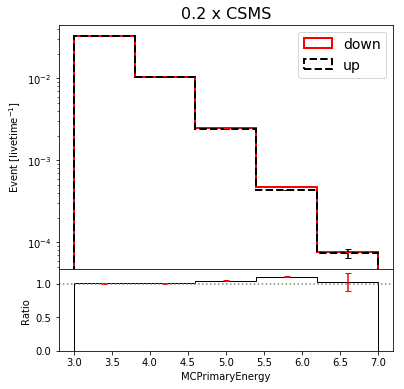

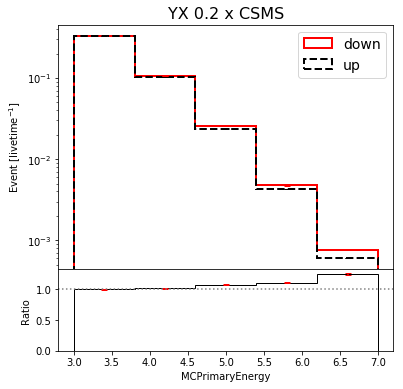

(array([1.00237116, 1.0156262 , 1.07547246, 1.10953233, 1.25342124]),
 array([3. , 3.8, 4.6, 5.4, 6.2, 7. ]))

In [39]:
ratio(csms_02['prim_1_down'],csms_02['weight_1_down'],csms_02['prim_1_up'],csms_02['weight_1_up'],'down','up','red','black',varbins,'0.2 x CSMS','MCPrimaryEnergy',r'$\rm Event\ [livetime^{-1}]$')
ratio(csms_02_yx['prim_1_down'],csms_02_yx['weight_1_down'],csms_02_yx['prim_1_up'],csms_02_yx['weight_1_up'],'down','up','red','black',varbins,'YX 0.2 x CSMS','MCPrimaryEnergy',r'$\rm Event\ [livetime^{-1}]$')

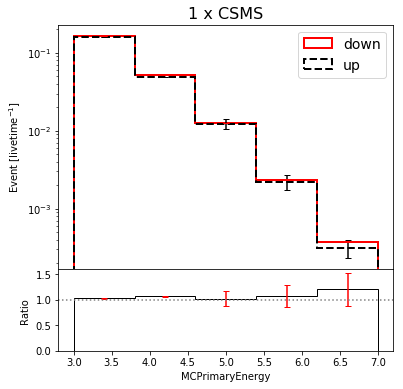

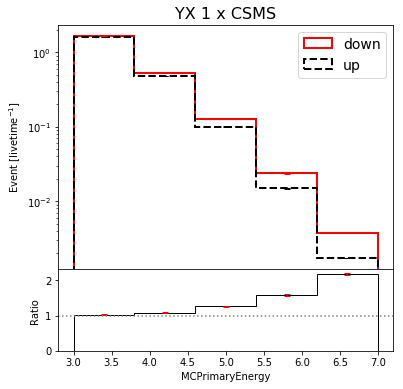

(array([1.02623927, 1.07857384, 1.25687962, 1.5819106 , 2.17927881]),
 array([3. , 3.8, 4.6, 5.4, 6.2, 7. ]))

In [40]:
ratio(csms_1['prim_1_down'],csms_1['weight_1_down'],csms_1['prim_1_up'],csms_1['weight_1_up'],'down','up','red','black',varbins,'1 x CSMS','MCPrimaryEnergy',r'$\rm Event\ [livetime^{-1}]$')
ratio(csms_1_yx['prim_1_down'],csms_1_yx['weight_1_down'],csms_1_yx['prim_1_up'],csms_1_yx['weight_1_up'],'down','up','red','black',varbins,'YX 1 x CSMS','MCPrimaryEnergy',r'$\rm Event\ [livetime^{-1}]$')

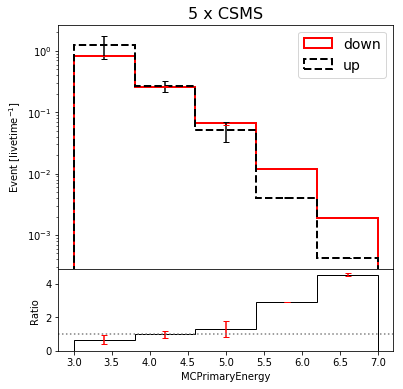

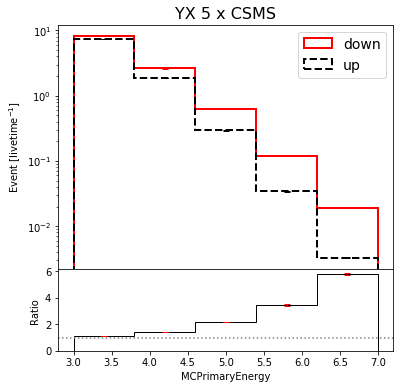

(array([1.10496724, 1.4097377 , 2.16186921, 3.45442267, 5.77964155]),
 array([3. , 3.8, 4.6, 5.4, 6.2, 7. ]))

In [41]:
ratio(csms_5['prim_1_down'],csms_5['weight_1_down'],csms_5['prim_1_up'],csms_5['weight_1_up'],'down','up','red','black',varbins,'5 x CSMS','MCPrimaryEnergy',r'$\rm Event\ [livetime^{-1}]$')
ratio(csms_5_yx['prim_1_down'],csms_5_yx['weight_1_down'],csms_5_yx['prim_1_up'],csms_5_yx['weight_1_up'],'down','up','red','black',varbins,'YX 5 x CSMS','MCPrimaryEnergy',r'$\rm Event\ [livetime^{-1}]$')

In [25]:
histerror(x,w,nbins,histtitle,c)

